# 1 - Imports and defining functions

In [1]:
import numpy as np

from pyFM.mesh import TriMesh
from pyFM.functional import FunctionalMapping

import meshplot as mp

def plot_mesh(myMesh,cmap=None):
    mp.plot(myMesh.vertlist, myMesh.facelist,c=cmap)
    
def double_plot(myMesh1,myMesh2,cmap1=None,cmap2=None):
    d = mp.subplot(myMesh1.vertlist, myMesh1.facelist, c=cmap1, s=[2, 2, 0])
    mp.subplot(myMesh2.vertlist, myMesh2.facelist, c=cmap2, s=[2, 2, 1], data=d)

def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

## 2- Loading Data

In [2]:
mesh1 = TriMesh('data/cat-00.off')
mesh2 = TriMesh('data/lion-00.off')
print(f'Mesh 1 : {mesh1.n_vertices:4d} vertices, {mesh1.n_faces:5d} faces\n'
      f'Mesh 2 : {mesh2.n_vertices:4d} vertices, {mesh2.n_faces:5d} faces')

double_plot(mesh1,mesh2)

Mesh 1 : 7207 vertices, 14410 faces
Mesh 2 : 5000 vertices,  9996 faces


# 3 - Computing the functional map

**Computing descriptors**

In [4]:
k1,k2 = 35,35 # Number of eigenvalues on source and Target
landmarks = np.loadtxt('data/landmarks.txt',dtype=int)[:5] # loading 5 landmarks
subsample_step = 5 # In order not to use too many descriptors*
descr_type = 'WKS' # WKS or HKS

model = FunctionalMapping(mesh1,mesh2)
model.preprocess(n_ev=(k1,k2),subsample_step = subsample_step, landmarks = landmarks, descr_type=descr_type,verbose=True);


Computing Laplacian spectrum
Compute linear FEM Laplace-Beltrami spectrum
Compute linear FEM Laplace-Beltrami spectrum

Computing descriptors
	Normalizing descriptors

	120 out of 600 possible descriptors kept
	Done


**Fitting the model**

Computing new descriptors
	Done

Optimization :
	35 Ev on source - 35 Ev on Target
	Using 120 Descriptors
	Hyperparameters :
		Descriptors preservation :1.0e+00
		Descriptors commutativity :1.0e-01
		Laplacian commutativity :1.0e-03

	Task : b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', funcall : 50, nit : 45, warnflag : 0
	Done in 0.56 seconds


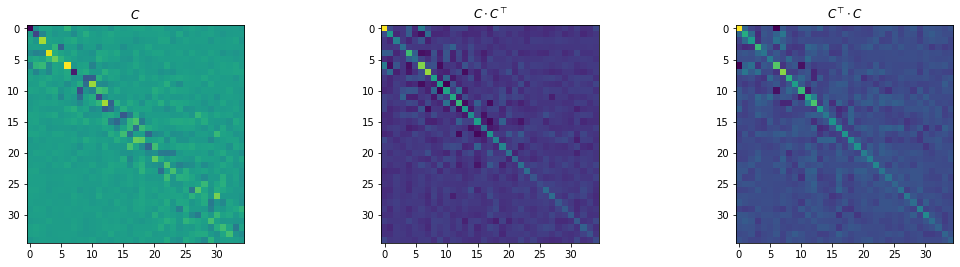

In [5]:
descr_mu = 1e0
lap_mu = 1e-3
descr_comm_mu=1e-1

model.fit(descr_mu = descr_mu,lap_mu = lap_mu, descr_comm_mu=descr_comm_mu, verbose=True)
model.display_C()

**Visualizing the associated point to point map**

In [6]:
p2p = model.p2p
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p]
double_plot(mesh1,mesh2,cmap1,cmap2)

# 4 - Refining the Functional Map
```model.FM``` returns the current state of functional map. One can change which one is returned by using ```model.change_FM_type(FM_type)```, as one can see below. 

**ICP**

In [7]:
model.icp_refine()
p2p = model.p2p
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p]
double_plot(mesh1,mesh2,cmap1,cmap2)

**Zoomout**

In [8]:
model.change_FM_type('classic') # We refine the first computed map, not the icp-refined one

model.zoomout_refine(nit=15, step = 1, subsample=None, use_ANN=False, verbose=True)
print(model.FM.shape)
p2p = model.p2p
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p]
double_plot(mesh1,mesh2,cmap1,cmap2)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:15<00:00,  1.10s/it]


(50, 50)
